## Simulation -> Prediction Experiments

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import pandas as pd
import os
import optuna
import matplotlib.pylab as plt
%matplotlib inline
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser
sys.path.append('../../data/')
sys.path.append('../../data/ml_mmrf')
sys.path.append('../../data/synthetic')
sys.path.append('../../data/semi_synthetic')
sys.path.append('..')
sys.path.append('../models/')
from ml_mmrf.ml_mmrf_v1.data import load_mmrf
from synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from ss_data import *
from models.ssm.ssm import SSM, SSMAtt
from models.ssm.ssm_baseline import SSMBaseline
from models.rnn import GRU
from models.utils import *
print(torch.__version__)

1.6.0


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
fold  = 1
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              suffix='_2mos_tr_ia15', \
                              restrict_markers=[], \
                              add_syn_marker=False, \
                              window='first_second', \
                              data_aug=False, ablation=False, feats=[])
ddata_notr = load_mmrf(fold_span = [fold], \
                              digitize_K = 20, \
                              digitize_method = 'uniform', \
                              suffix='_2mos_ia15', \
                              restrict_markers=[], \
                              add_syn_marker=False, \
                              window='all', \
                              data_aug=False)

# Atr = ddata[fold]['train']['a']
# Av = ddata[fold]['valid']['a']
# Ate = ddata[fold]['test']['a']
# A = np.concatenate((Atr,Av,Ate),axis=0)
# ptr = ddata[fold]['train']['pids']
# pv = ddata[fold]['valid']['pids']
# pte = ddata[fold]['test']['pids']
# p = np.concatenate((ptr,pv,pte),axis=0)

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_tr_ia15.pkl
{'MMRF_1951', 'MMRF_1866', 'MMRF_2225', 'MMRF_1064'}
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_ia15.pkl
Digitizing outcomes ymax: 41.65
20 19 20


In [4]:
def gen_labels(fold=1): 
    trt_pids = list(np.concatenate((ddata[fold]['train']['pids'],ddata[fold]['valid']['pids'],ddata[fold]['test']['pids'])))
    trt_labels = np.concatenate((ddata[fold]['train']['ys_seq'],ddata[fold]['valid']['ys_seq'],ddata[fold]['test']['ys_seq']))
    trt_a = np.concatenate((ddata[fold]['train']['a'],ddata[fold]['valid']['a'],ddata[fold]['test']['a']),axis=0)
    trt_ce   = np.concatenate((ddata[fold]['train']['ce'],ddata[fold]['valid']['ce'],ddata[fold]['test']['ce']))
    print(len(trt_pids))
    print(len(trt_labels))
    print(len(trt_ce))
    
    pidste = list(ddata_notr[fold]['test']['pids'])
    pidsv  = list(ddata_notr[fold]['valid']['pids'])
    pidstr = list(ddata_notr[fold]['train']['pids'])
    train_idxs = []; valid_idxs = []; test_idxs = []
    Ytrain  = []; Yvalid = []; Ytest = []
    CEtrain = []; CEvalid = []; CEtest = []
    pidstr_fin = []; pidsv_fin = []; pidste_fin = []
    
    for oidx, pid in enumerate(pidstr): 
        if pid in trt_pids: 
            idx = trt_pids.index(pid)
#             print(trt_a[idx,:,-2])
#             print(ddata_notr[fold]['train']['a'][oidx,:,-2])
#             print()
            label = trt_labels[idx]; ce = trt_ce[idx]
            train_idxs.append(oidx)
            Ytrain.append(label)
            CEtrain.append(ce)
            pidstr_fin.append(pid)
    print(f'total number of ppl in train set (no tr): {len(pidstr)}')
    print(f'number of ppl in train set with second line info: {len(Ytrain)}')
    
    for oidx, pid in enumerate(pidsv): 
        if pid in trt_pids: 
            idx = trt_pids.index(pid)
#             print(trt_a[idx,:,-2])
#             print(ddata_notr[fold]['valid']['a'][oidx,:,-2])
#             print()
            label = trt_labels[idx]; ce = trt_ce[idx]
            valid_idxs.append(oidx)
            Yvalid.append(label)
            CEvalid.append(ce)
            pidsv_fin.append(pid)
    print(f'total number of ppl in valid set (no tr): {len(pidsv)}')
    print(f'number of ppl in valid set with second line info: {len(Yvalid)}')
    
    for oidx, pid in enumerate(pidste): 
        if pid in trt_pids: 
            idx = trt_pids.index(pid)
#             print(trt_a[idx,:,-2])
#             print(ddata_notr[fold]['test']['a'][oidx,:,-2])
#             print()
            label = trt_labels[idx]; ce = trt_ce[idx]
            test_idxs.append(oidx)
            Ytest.append(label)
            CEtest.append(ce)
            pidste_fin.append(pid)
    print(f'total number of ppl in test set (no tr): {len(pidste)}')
    print(f'number of ppl in test set with second line info: {len(Ytest)}')
    
    return (train_idxs, valid_idxs, test_idxs), (np.array(Ytrain), np.array(Yvalid), np.array(Ytest)), (np.array(CEtrain), np.array(CEvalid), np.array(CEtest)), (pidstr_fin, pidsv_fin, pidste_fin)

In [5]:
def setup_torch_dataset(ddata, fold, tvt, device=None, oversample=True, att_mask=False, batch_size=600):
    if device is not None: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32')).to(device)
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32')).to(device)
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32')).to(device)
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32')).to(device)
    else: 
        B  = torch.from_numpy(ddata[fold][tvt]['b'].astype('float32'))
        X  = torch.from_numpy(ddata[fold][tvt]['x'].astype('float32'))
        A  = torch.from_numpy(ddata[fold][tvt]['a'].astype('float32'))
        M  = torch.from_numpy(ddata[fold][tvt]['m'].astype('float32'))
    y_vals   = ddata[fold][tvt]['ys_seq'][:,0].astype('float32')
#     idx_sort = np.argsort(y_vals)

    if 'digitized_y' in ddata[fold][tvt]:
        print ('using digitized y')
        Y  = torch.from_numpy(ddata[fold][tvt]['digitized_y'].astype('float32'))
    else:
        Y  = torch.from_numpy(ddata[fold][tvt]['ys_seq'][:,[0]]).squeeze()

    if device is not None: 
        Y = Y.to(device)
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32')).to(device)
    else: 
        CE = torch.from_numpy(ddata[fold][tvt]['ce'].astype('float32'))

    if att_mask: 
        attn_shape  = (A.shape[0],A.shape[1],A.shape[1])
        Am   = get_attn_mask(attn_shape, ddata[fold][tvt]['a'].astype('float32'), device)
        data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort], Am[idx_sort])
    else: 
#         data = TensorDataset(B[idx_sort], X[idx_sort], A[idx_sort], M[idx_sort], Y[idx_sort], CE[idx_sort])
        data = TensorDataset(B, X, A, M, Y, CE)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    return data, data_loader


### Predicting TR Response (2nd Line Therapy)

In [6]:
model_path = './checkpoints/new_ablation/mmfold_simulation_ia15164_attn_transition__ssmepoch=14802-val_loss=57.28.ckpt'
# model_path = './checkpoints/new_ablation/gru_simulation_ia15epoch=00303-val_loss=109.99.ckpt'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device  = torch.device('cpu')
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
hparams    = checkpoint['hyper_parameters']
fold = hparams['fold']
tvt  = 'test'
hparams['include_baseline'] = 'all'
hparams['include_treatment'] = 'lines'
del hparams['trial']

if 'ssm' in model_path: 
    trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, \
                                 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic, 'inftype': hparams.inftype})
    model = SSM(trial, **hparams); model.setup(1)
elif 'gru' in model_path: 
    trial = optuna.trial.FixedTrial({'bs': hparams.bs,'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, \
                                     'reg_type': hparams.reg_type, 'dim_hidden': hparams.dim_hidden}) 
    model = GRU(trial, **hparams); model.setup(1)
print('loading',model_path)

model.load_state_dict(checkpoint['state_dict'])
model.to(device)    
# data, data_loader   = model.load_helper(tvt, device=device)
data, data_loader   = setup_torch_dataset(ddata_notr, fold, tvt, device=device)
(B, X, A, M, Y, CE) = data_loader.dataset.tensors 
# print(X.shape)
print(A.shape)

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_ia15.pkl
Digitizing outcomes ymax: 41.65
20 19 20
using relu in inf. network
loading ./checkpoints/new_ablation/mmfold_simulation_ia15164_attn_transition__ssmepoch=14802-val_loss=57.28.ckpt
using digitized y
torch.Size([251, 36, 9])


In [7]:
T_forward = 30
T_condition = 5

# restrict labels 
idxs, Ys, CEs, PIDS = gen_labels(fold=fold)
train_idxs, valid_idxs, test_idxs = idxs 
Ytrain, Yvalid, Ytest = Ys 
CEtrain, CEvalid, CEtest = CEs
PIDS = [np.array(l) for l in PIDS]
pids_train, pids_valid, pids_test = PIDS
if tvt == 'train': 
    Bp = B[train_idxs]; Ap = A[train_idxs]; Xp = X[train_idxs]; Mp = M[train_idxs]; Yp = torch.Tensor(Ytrain).to(device); CEp = torch.Tensor(CEtrain).to(device)
elif tvt == 'valid': 
    Bp = B[valid_idxs]; Ap = A[valid_idxs]; Xp = X[valid_idxs]; Mp = M[valid_idxs]; Yp = torch.Tensor(Yvalid).to(device); CEp = torch.Tensor(CEvalid).to(device)
elif tvt == 'test': 
    Bp = B[test_idxs]; Ap = A[test_idxs]; Xp = X[test_idxs]; Mp = M[test_idxs]; Yp = torch.Tensor(Ytest).to(device); CEp = torch.Tensor(CEtest).to(device)

# model.inspect(T_forward, T_condition, B, X, A, M, Y, CE, restrict_lens = False, nsamples = 3, eps = 0.)
if 'gru' in model_path: 
    _, _, _, _, x_cond, x_forward, tensors_restr, idx_select = model.inspect(T_forward, T_condition, Bp, Xp, Ap, Mp, Yp, CEp, restrict_lens = False)
else: 
    print('here')
#     _, _, _, _, x_cond, x_forward, tensors_restr, idx_select = model.inspect(T_forward, T_condition, Bp, Xp, Ap, Mp, Yp, CEp, restrict_lens = False, nsamples = 3, eps = 0.)
    x_cond, tensors_restr, idx_select = model.inspect_trt(Bp, Xp, Ap, Mp, Yp, CEp, nsamples=3)
    x_forward = x_cond
(Br,Xr,Ar,Mr,Yr,CEr) = tensors_restr
b = pt_numpy(Br);x = pt_numpy(Xr);a = pt_numpy(Ar);m = pt_numpy(Mr);y = pt_numpy(Yr.squeeze());ce = pt_numpy(CEr.squeeze())
print(x_forward.shape)
x_forward_n = pt_numpy(x_forward); x_cond_n = pt_numpy(x_cond)
idx_bool = pt_numpy(idx_select)
idxs = np.array(np.where(idx_bool==1.)[0])
print(len(idxs))
if tvt == 'train': 
    pids_train = pids_train[idxs]
    final_pids = pids_train
elif tvt == 'valid': 
    pids_valid = pids_valid[idxs]
    final_pids = pids_valid
elif tvt == 'test': 
    pids_test = pids_test[idxs]
    final_pids = pids_test

379
379
379
total number of ppl in train set (no tr): 500
number of ppl in train set with second line info: 202
total number of ppl in valid set (no tr): 189
number of ppl in valid set with second line info: 70
total number of ppl in test set (no tr): 251
number of ppl in test set with second line info: 107
here
> /afs/csail.mit.edu/u/z/zeshanmh/research/ief/ief_core/models/ssm/ssm.py(327)inspect_trt()
-> for i in range(X.shape[0]):


(Pdb)  c


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


RuntimeError: Cannot pack empty tensors.

In [8]:
print(y.shape)
print(b.shape)
print(len(final_pids))

(107,)
(107, 16)
107


In [10]:
sample = 'cond'
if sample == 'forward': 
    x_seq = x_forward_n
else: 
    x_seq = x_cond_n
b_names = ddata_notr[fold][tvt]['feature_names'].tolist()
x_names = ddata_notr[fold][tvt]['feature_names_x'].tolist()
print(f'x names: {x_names}')
syn_x_sample   = np.zeros((x_seq.shape[0],x_seq.shape[1],1))
syn_x   = np.zeros((x.shape[0],x.shape[1],1))

for i in range(x_seq.shape[0]): 
    tseq = np.zeros((x_seq.shape[1],))
    tseq2= np.zeros((x.shape[1],))
    if b[i,b_names.index('igg_type')] == 1.: 
        tseq += x_seq[i,:,x_names.index('serum_igg')]
        tseq2 += x[i,:,x_names.index('serum_igg')]
    elif b[i,b_names.index('iga_type')] == 1.: 
        tseq += x_seq[i,:,x_names.index('serum_iga')]
        tseq2 += x[i,:,x_names.index('serum_iga')]
    elif b[i,b_names.index('igm_type')] == 1.: 
        tseq += x_seq[i,:,x_names.index('serum_igm')]
        tseq2 += x[i,:,x_names.index('serum_igm')]

    if b[i,b_names.index('kappa_type')] == 1.: 
        tseq += x_seq[i,:,x_names.index('serum_kappa')]
        tseq2 += x[i,:,x_names.index('serum_kappa')]
    elif b[i,b_names.index('lambda_type')] == 1.: 
        tseq += x_seq[i,:,x_names.index('serum_lambda')] 
        tseq2 += x[i,:,x_names.index('serum_lambda')] 
    
    syn_x_sample[i] = tseq[:,np.newaxis]
    syn_x[i] = tseq2[:,np.newaxis]

new_x_sample = np.concatenate((x_seq,syn_x_sample),axis=-1)
new_x = np.concatenate((x,syn_x),axis=-1)
mseq     = np.ones((new_x.shape[0],new_x.shape[1],1))
new_m = np.concatenate((m,mseq),axis=-1)
print(new_m.shape)
x_names.append('syn_marker')
midx = x_names.index('serum_m_protein'); sidx = x_names.index('syn_marker')
pd_idxs    = np.where(y == 1)[0]
nonpd_idxs = np.where(y == 0)[0]
# print(pd_idxs)

print(new_x_sample.shape)
print(new_x.shape)
print(a.shape)

x names: ['cbc_abs_neut', 'chem_albumin', 'chem_bun', 'chem_calcium', 'chem_creatinine', 'chem_glucose', 'cbc_hemoglobin', 'serum_kappa', 'serum_m_protein', 'cbc_platelet', 'chem_totprot', 'cbc_wbc', 'serum_iga', 'serum_igg', 'serum_igm', 'serum_lambda']
(107, 36, 17)
(107, 35, 17)
(107, 36, 17)
(107, 36, 9)


No handles with labels found to put in legend.


Text(0.5, 0.92, 'Expanded Feature Set over Time for All Patients')

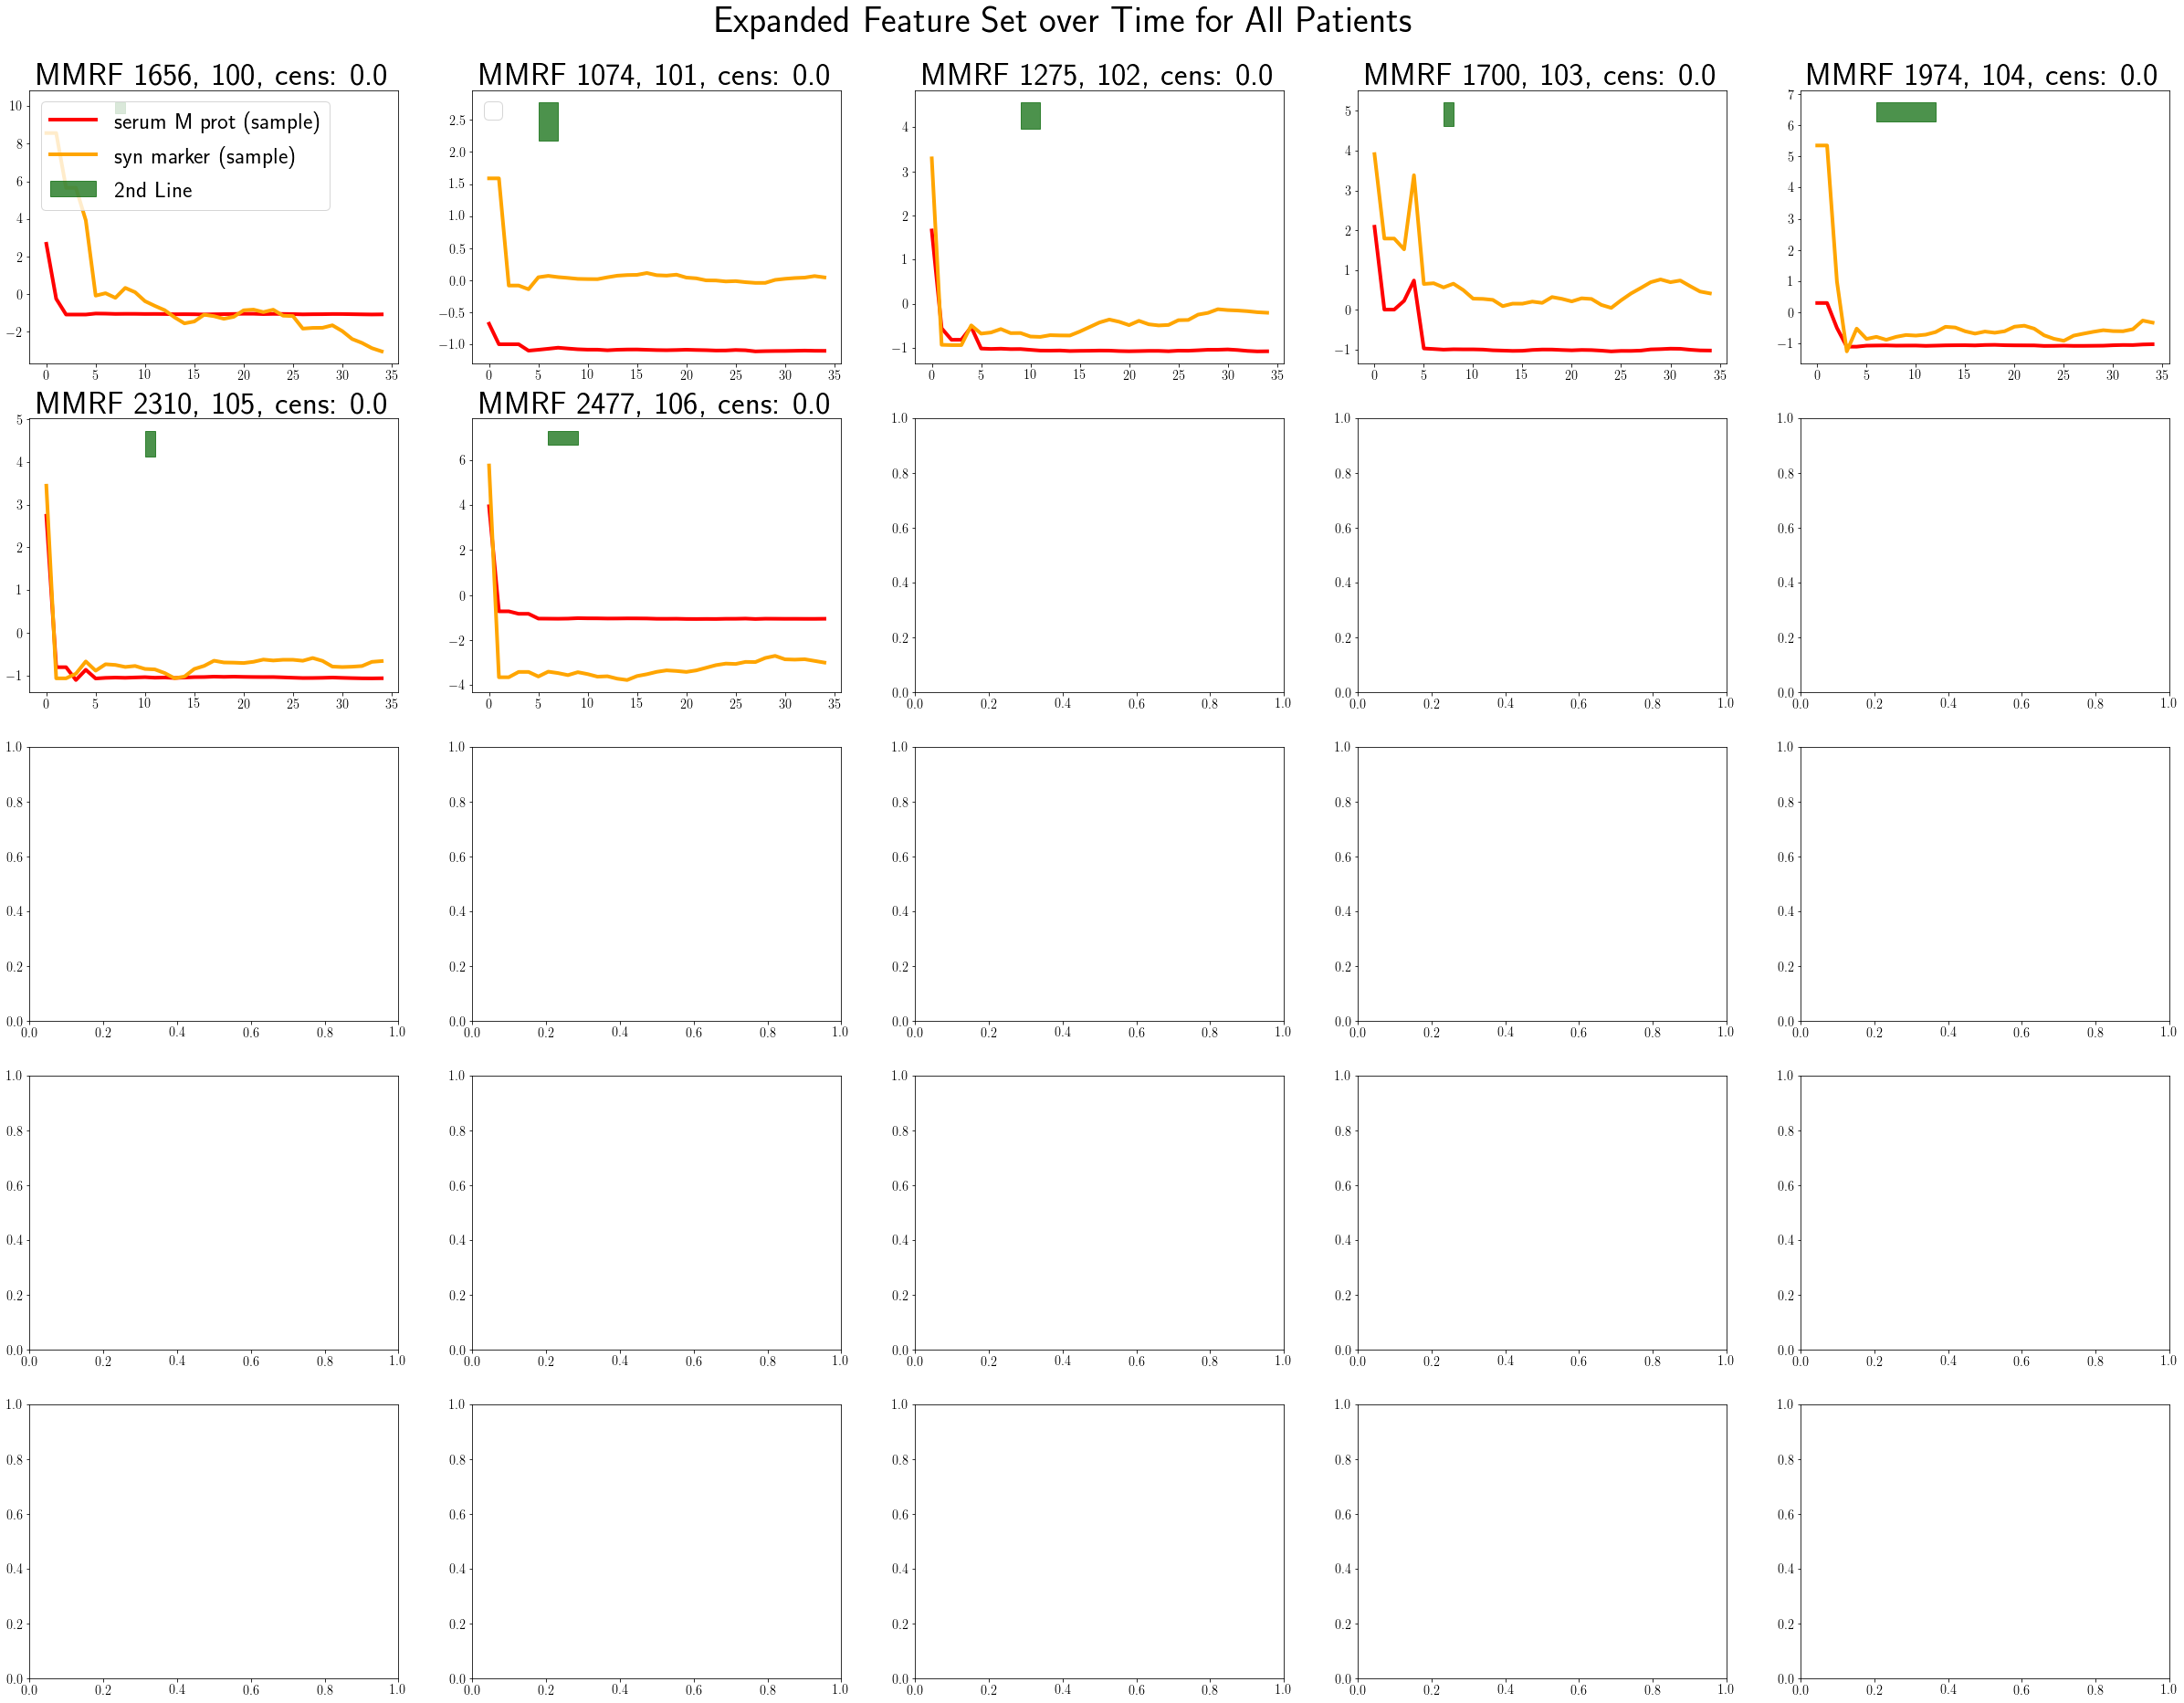

In [18]:
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(np.arange(new_x_sample.shape[0])[100:]): 
#     if ddata[1][split]['pids'][idx] == 'MMRF_1842':
#         import pdb; pdb.set_trace()
    second_line = a[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
#     orig_example = new_x[idx]
#     orig_example[np.where(new_m[idx] == 0.)] = np.nan
    sample = new_x_sample[idx]
#     sample[np.where(m[idx] == 0.)] = np.nan
    if i == 0: 
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, c='red', linestyle='--', label='serum M prot (raw)')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,sidx], linewidth=4, c='orange', linestyle='--', label='syn marker (raw)')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,midx], linewidth=4, c='red', label='serum M prot (sample)')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,sidx], linewidth=4, c='orange', label='syn marker (sample)')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4, label='serum kappa')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4, label='serum lambda')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4, label='urine M prot')
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    else: 
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], c='red', linestyle='--', linewidth=4)
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,sidx], c='orange', linestyle='--', linewidth=4)
        ax[i].plot(np.arange(sample.shape[0]), sample[:,midx], linewidth=4, c='red')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,sidx], linewidth=4, c='orange')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4)
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4)
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4)
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)
        
    s = final_pids[idx].split('_')[1]
    ax[i].set_title(f'MMRF {s}, {idx}, cens: {ce[idx]}', fontsize=35)
    if i == 0 or i == 1: 
        ax[i].legend(fontsize=25, loc='upper left')
fig.suptitle('Expanded Feature Set over Time for All Patients', fontsize=40, y=0.92)
# fig.savefig(f'restricted_feat_pds_expanded.pdf',bbox_inches='tight')

### Plot

0
1


No handles with labels found to put in legend.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Text(0.5, 0.92, 'Expanded Feature Set over Time for PD Patients')

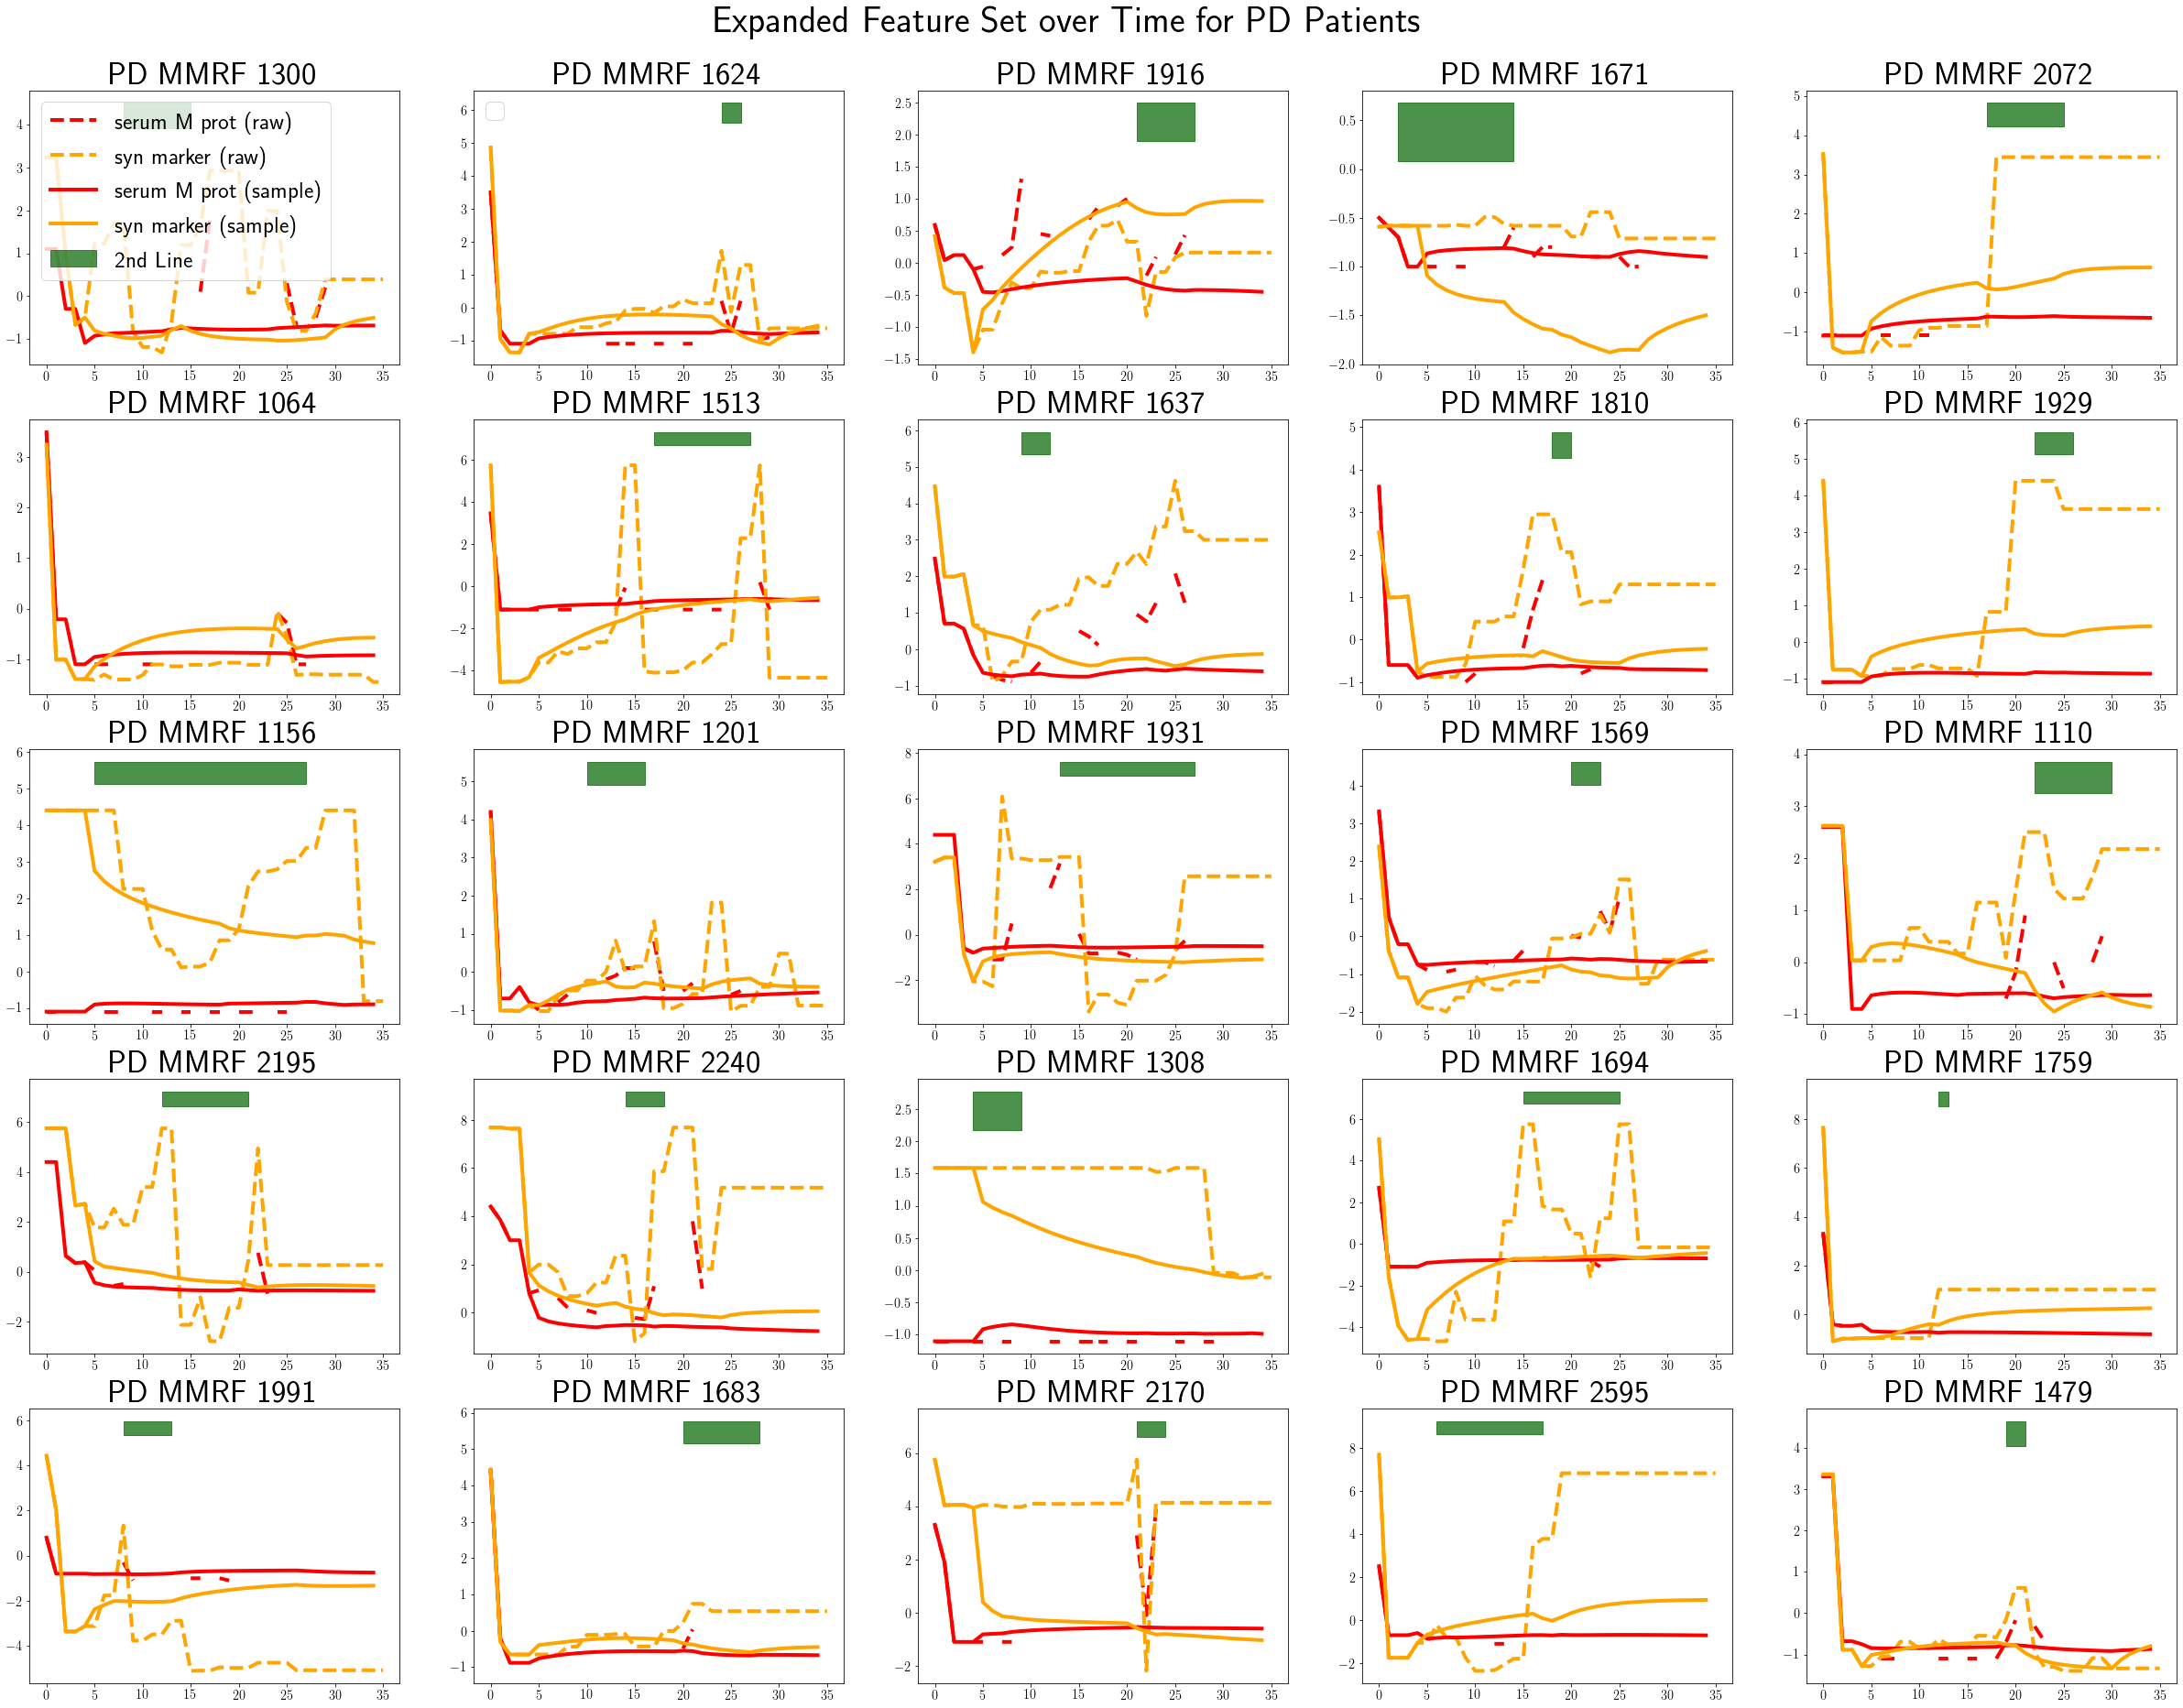

In [11]:
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(pd_idxs[:25]): 
#     if ddata[1][split]['pids'][idx] == 'MMRF_1842':
#         import pdb; pdb.set_trace()
    print(i)
#     if final_pids[idx] == 'MMRF_1866': 
#         import  pdb; pdb.set_trace()
    second_line = a[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = new_x[idx]
    orig_example[np.where(new_m[idx] == 0.)] = np.nan
    sample = new_x_sample[idx]
#     sample[np.where(m[idx] == 0.)] = np.nan
    if i == 0: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, c='red', linestyle='--', label='serum M prot (raw)')
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,sidx], linewidth=4, c='orange', linestyle='--', label='syn marker (raw)')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,midx], linewidth=4, c='red', label='serum M prot (sample)')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,sidx], linewidth=4, c='orange', label='syn marker (sample)')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4, label='serum kappa')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4, label='serum lambda')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4, label='urine M prot')
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    else: 
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], c='red', linestyle='--', linewidth=4)
        ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,sidx], c='orange', linestyle='--', linewidth=4)
        ax[i].plot(np.arange(sample.shape[0]), sample[:,midx], linewidth=4, c='red')
        ax[i].plot(np.arange(sample.shape[0]), sample[:,sidx], linewidth=4, c='orange')
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,kidx], linewidth=4)
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,lidx], linewidth=4)
#         ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,umidx], linewidth=4)
        ymax = ax[i].get_ylim()[1]+0.05
        ys = np.array([ymax for x in range(len(sline_ts))])
        ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7)
        
    s = final_pids[idx].split('_')[1]
    ax[i].set_title(f'PD MMRF {s}', fontsize=35)
    if i == 0 or i == 1: 
        ax[i].legend(fontsize=25, loc='upper left')
fig.suptitle('Expanded Feature Set over Time for PD Patients', fontsize=40, y=0.92)
# fig.savefig(f'restricted_feat_pds_expanded.pdf',bbox_inches='tight')

In [12]:
print(syn_x_sample.shape)
print(y.shape)
ave1 = np.mean(syn_x_sample,axis=1)
ave2 = np.mean(syn_x_sample[:,1:,:]-syn_x_sample[:,:-1,:],axis=1)
temp = np.sign(syn_x_sample[:,1:,:]-syn_x_sample[:,:-1,:])
ave3 = []
for i in range(temp.shape[0]): 
    values, counts = np.unique(temp[i],return_counts=True)
    ind = np.argmax(counts)
    ave3.append(values[ind])
ave3 = np.array(ave3)
print(ave1.shape)
print(ave2.shape)
ave3[np.where(ave3==-1.)[0]]=0.
y_pred3 = ave3
y_pred_ssm_h=np.array([0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])

(107, 35, 1)
(107,)
(107, 1)
(107, 1)


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
event_obs = (1.-ce).ravel()
idx       = np.where(event_obs>0)[0]
y_pred = y_pred3[idx]; y_true = y[idx]
print(f'predictions: {y_pred}')
print(f'ground truth: {y_true}')
auc    = roc_auc_score(y_true, y_pred, average='weighted')
print(auc)

predictions: [1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
ground truth: [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
0.4676360225140713
